<a href="https://colab.research.google.com/github/anderm18/CurlingVAR/blob/main/CurlingSegmentationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import PIL
import cv2
import pandas as pd
import numpy as np
from google.colab import drive
from IPython.display import Image
from matplotlib import pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.models.detection import maskrcnn_resnet50_fpn

In [2]:
!pip install defisheye

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 866.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 13.3 MB/s eta 0:00:00


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CurlingDataset(Dataset):

  _train = None
  _test = None
  _validate = None

  def __init__(self, csv_loc, img_dir, set_type="train", transform=None, target_transform=None):
    self.data = pd.read_csv(csv_loc)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform


    if type(CurlingDataset._train) == type(None):
      print("Performing a split")
      CurlingDataset._train, CurlingDataset._test, CurlingDataset._validate = self.__split()

    self.data = CurlingDataset._train if set_type == "train" else (CurlingDataset._test if set_type == "test" else CurlingDataset._validate)

  def __len__(self):
    return len(self.data)

  def __split(self):

    train, test = train_test_split(self.data, train_size=.70, stratify=self.data['empty'])
    test, validate = train_test_split(test, train_size=.50, stratify=test['empty'])

    return train, test, validate

  def __getitem__(self, index):

    img_path = os.path.join(self.img_dir, self.data.iloc[index, 2])
    image = PIL.Image.open(img_path).convert('RGB')
    label = torch.tensor(int(self.data.iloc[index, 3]))

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="train",
    transform=transform
)

test_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="test",
    transform=transform
)

validate_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="validate",
    transform=transform
)

Performing a split


In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)
validate_dataloader = DataLoader(validate_data, batch_size=32)

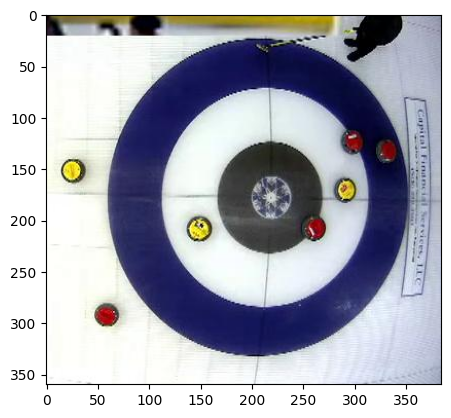

In [ ]:
img = PIL.Image.open("/content/drive/My Drive/achilles2022_out/images/100.jpg")
plt.imshow(img)

In [ ]:
def fprime(x, sig):

  exp1 = np.exp((-.5 * (x + 1))**2) / (sig**2)
  exp2 = np.exp((-.5 * (x - 1))**2) / (sig**2)
  return (exp1 - exp2)/2



def derivate(img):
  plt.imshow(img, cmap='gray')

  x_img = cv2.Sobel(img,  cv2.CV_8UC1, 0, 1)

  return x_img

[[[162.5 180.5  33.8]
  [170.5 151.5  16.6]
  [240.5 149.5   9.6]
  [ 97.5 187.5  10. ]]]


<ipython-input-7-52e02796f5e9>:7: RuntimeWarning: overflow encountered in ushort_scalars
  dist = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


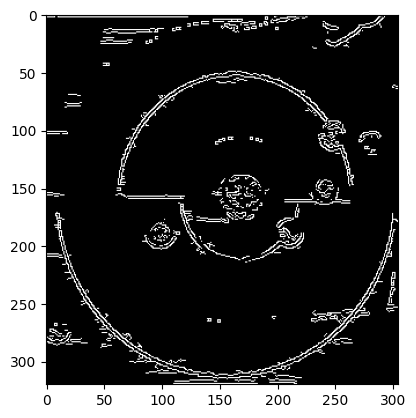

320 305
[[255 255 255 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [ ]:
def correct_perspective(img):
  img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

  img = cv2.Sobel(img[20:340, 50:355], cv2.CV_8UC1, 0, 1)
  # blur = cv2.GaussianBlur(img, (7, 7), 1.5)
  img = np.where((255 - img) < 100,255,img+100)
  dist = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
  img = cv2.Canny(img, 100, 300)
  detected_circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20, param1=20, param2=20, minRadius=1, maxRadius=40)
  print(detected_circles)
  if detected_circles is not None:

    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))
    for pt in detected_circles[0, :]:
      image_center = (img.shape[1] // 2, img.shape[0] // 2)
      central = min(detected_circles[0, :], key=lambda x: dist(image_center, (x[0], x[1])))

      a, b, r = pt[0], pt[1], pt[2]
      cv2.circle(img, (a, b), r, (0, 255, 0), 2)
      cv2.circle(img, (a, b), 1, (0, 0, 255), 3)

      distance = dist((a, b), (central[0], central[1]))


  plt.imshow(img, cmap='gray')
  plt.show()
  # plt.imshow(img)
  # plt.show()
  rows, cols = img.shape
  print(rows, cols)

  print(img)
  pts = np.float32([[5, 0], [5, 315], [300, 5], [300, 310]])
  pts2 = np.float32([[0, 0], [0, 320], [305, 0], [305, 320]])

correct_perspective("/content/drive/My Drive/achilles2022_out/images/100.jpg")

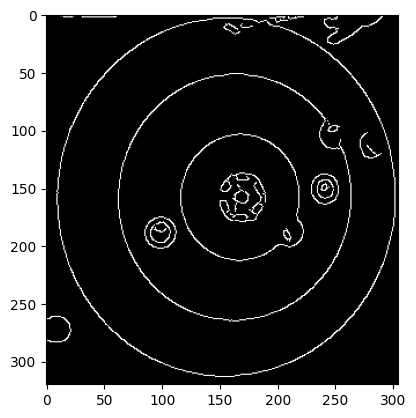

<ipython-input-32-5bd603313c77>:9: RuntimeWarning: overflow encountered in scalar subtract
  dist = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


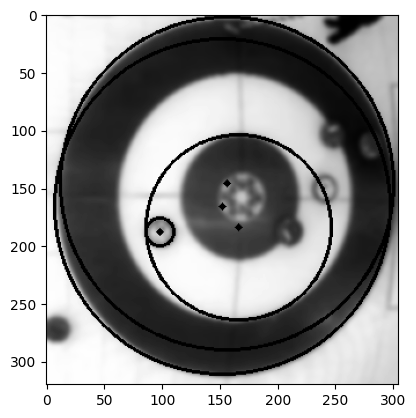

In [ ]:
img = cv2.imread("/content/drive/My Drive/achilles2022_out/images/100.jpg", cv2.IMREAD_GRAYSCALE)[20:340, 50:355]

img = img.astype(float)
sigma = 2
low, high = 50, 100
ksize = (4*sigma+1, 4*sigma+1)
img = cv2.GaussianBlur(img, ksize, sigma).astype(np.uint8)

dist = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

plt.imshow(img, cmap='gray')
edge = cv2.Canny(img, low, high)
circles = cv2.HoughCircles(edge, cv2.HOUGH_GRADIENT,1,20, \
                            param1=50,param2=59,minRadius=5,maxRadius=0)

plt.imshow(edge, cmap='gray')
plt.show()

if circles is not None:
    # Convert the circle parameters a, b and r to integers.
    circles = np.uint16(np.around(circles))
    for pt in circles[0, :]:
      image_center = (img.shape[1] // 2, img.shape[0] // 2)
      central = min(circles[0, :], key=lambda x: dist(image_center, (x[0], x[1])))

      a, b, r = pt[0], pt[1], pt[2]
      cv2.circle(img, (a, b), r, (0, 255, 0), 2)
      cv2.circle(img, (a, b), 1, (0, 0, 255), 3)

      distance = dist((a, b), (central[0], central[1]))
plt.imshow(img, cmap='gray')
plt.show()

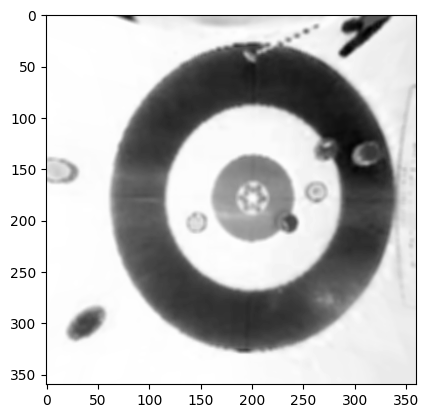

<ipython-input-25-70799743eba1>:52: RuntimeWarning: overflow encountered in scalar subtract
  dist = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


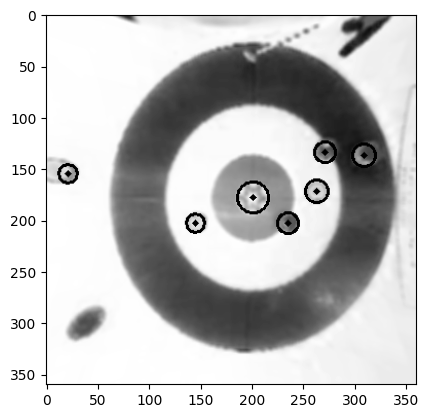

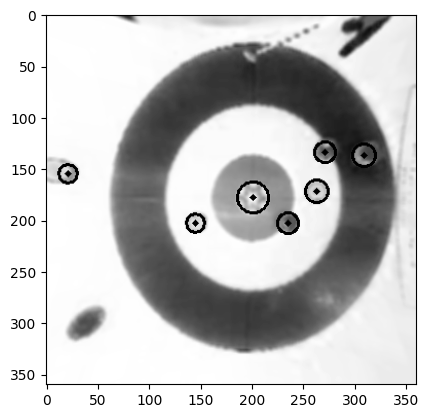

In [25]:
im = cv2.imread("/content/drive/My Drive/achilles2022_out/images/100.jpg")

from defisheye import Defisheye

dtype = 'linear'
format = 'fullframe'
fov = 150
pfov = 120

obj = Defisheye("/content/drive/My Drive/achilles2022_out/images/100.jpg", dtype=dtype, format=format, fov=fov, pfov=pfov)


# To use the converted image in memory
new_image = obj.convert()

# plt.imshow(im)
# plt.show()

# print(new_image)
# plt.imshow(new_image)
# plt.show()

# img = new_image.astype(float)
# sigma = 2
# low, high = 50, 100
# ksize = (4*sigma+1, 4*sigma+1)
# img = cv2.GaussianBlur(img, ksize, sigma).astype(np.uint8)

# dist = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# plt.imshow(img, cmap='gray')
# edge = cv2.Canny(img, low, high)
# print(edge)

img = cv2.cvtColor(new_image, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(img)
value = 100
lim = 255 - value

v[v > lim] = 255
v[v <= lim] += value

img = cv2.merge((h, s, v))
img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img, (5, 5), 2)

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, \
                            param1=150,param2=17,minDist=10, dp=1.1, minRadius=8,maxRadius=20)

plt.imshow(img, cmap='gray')
plt.show()
dist = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

if circles is not None:
    # Convert the circle parameters a, b and r to integers.
    circles = np.uint16(np.around(circles))
    for pt in circles[0, :]:
      image_center = (img.shape[1] // 2, img.shape[0] // 2)
      central = min(circles[0, :], key=lambda x: dist(image_center, (x[0], x[1])))

      a, b, r = pt[0], pt[1], pt[2]
      cv2.circle(img, (a, b), r, (0, 255, 0), 2)
      cv2.circle(img, (a, b), 1, (0, 0, 255), 3)

      distance = dist((a, b), (central[0], central[1]))
plt.imshow(img, cmap='gray')
plt.show()

# detector = cv2.SimpleBlobDetector_create()
# keypoints = detector.detect(img)
# for keypoint in keypoints:
#     x = int(keypoint.pt[0])
#     y = int(keypoint.pt[1])
#     r = int(keypoint.size / 2)
#     cv2.circle(img, (x, y), r, (0, 255, 0), 2)

plt.imshow(img, cmap='gray')
plt.show()